# 房价预测模型训练与评价

**目标**: 利用小区的各项特征，构建多个机器学习模型来预测其均价（PRI），并对这些模型的性能进行比较和评估。

**流程**:
1.  **数据加载与准备**: 加载由数据处理流水线生成的`data_predict.csv`，并划分为训练集和测试集。
2.  **基线模型训练**: 训练传统的机器学习模型作为性能基准。
     - 随机森林 (Random Forest)
     - 决策树 (Decision Tree) (使用GridSearch调优)
     - 梯度提升回归 (Gradient Boosting)
3.  **高级模型探索**: 训练更复杂的模型。
     - 神经网络 (Neural Network) (采用多个不同优化器的模型进行集成平均)
     - 堆叠 (Stacking) (将神经网络的预测作为特征，输入给XGBoost元模型)
4.  **模型性能综合比较**: 汇总所有模型的R²分数，通过可视化图表直观比较它们的预测能力。

## 1. 导入库与环境配置

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

# Scikit-learn 模型
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 其他模型
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# 导入项目配置
from config.config import (
    PREDICT_DATA_FILENAME,
    COMMUNITIES_DATA_PROCESSED_DIR,
    PREDICTION_TARGET_COL,
    PREDICTION_TEST_SIZE,
    PREDICTION_RANDOM_STATE,
    VIS_STYLE,
    VIS_FONT,
    PREDICTION_RESULTS_DIR,
    FEATURES_RESULTS_DIR,
    FIGURES_DIR
)
# 创建目录
os.makedirs(PREDICTION_RESULTS_DIR, exist_ok=True)
os.makedirs(FEATURES_RESULTS_DIR, exist_ok=True)

In [3]:
# 设置绘图样式
plt.style.use(VIS_STYLE)
plt.rcParams['font.family'] = [VIS_FONT]
plt.rcParams['axes.unicode_minus'] = False

## 2. 加载数据与准备

In [4]:
# 加载为预测任务准备的专用数据
predict_data_path = f'{COMMUNITIES_DATA_PROCESSED_DIR}/{PREDICT_DATA_FILENAME}'
df = pd.read_csv(predict_data_path)

# 准备特征 (X) 和目标 (y)
X = df.drop(PREDICTION_TARGET_COL, axis=1)
y = df[PREDICTION_TARGET_COL]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=PREDICTION_TEST_SIZE,
    random_state=PREDICTION_RANDOM_STATE
)

print(f'训练集大小: {X_train.shape}')
print(f'测试集大小: {X_test.shape}')

训练集大小: (1563, 22)
测试集大小: (671, 22)


## 3. 模型训练与评价
逐一训练各个模型，并记录它们的R²分数以便后续比较。

In [5]:
# 用于存储所有模型性能的字典
r2_scores = {}

### 3.1 随机森林 (Random Forest)

In [6]:
# 训练模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=PREDICTION_RANDOM_STATE)
rf_model.fit(X_train, y_train)

# 预测与评估
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
r2_scores['随机森林'] = r2_rf

print(f"随机森林 - R² 分数: {r2_rf:.4f}")

随机森林 - R² 分数: 0.4179


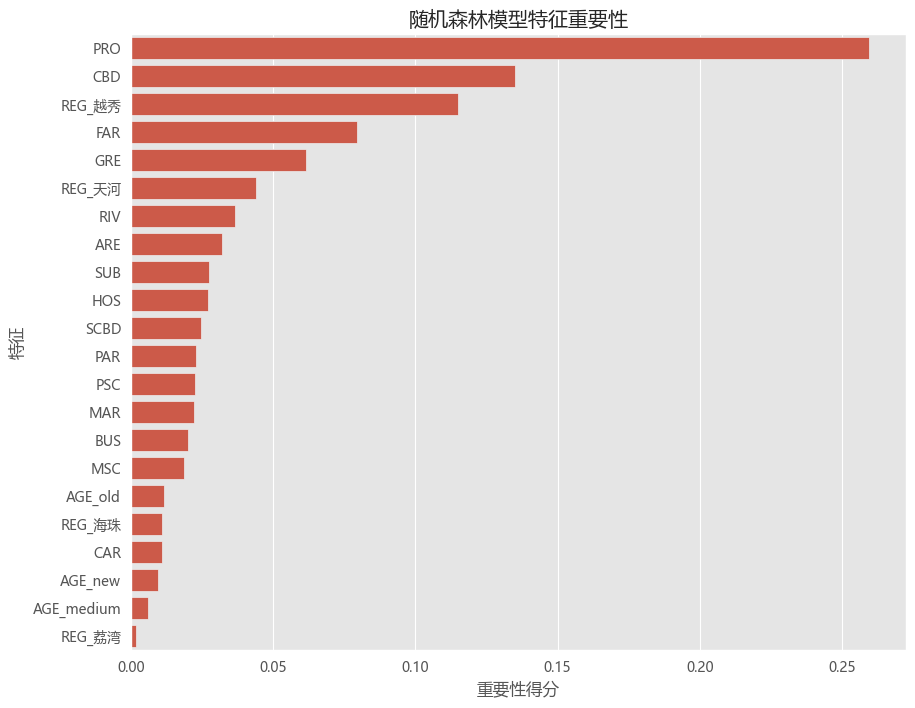

In [7]:
# 可视化特征重要性
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('随机森林模型特征重要性')
plt.xlabel('重要性得分')
plt.ylabel('特征')
plt.savefig(f'{FEATURES_RESULTS_DIR}/rf_feature_importance.png')
plt.show()

### 3.2 决策树 (Decision Tree with GridSearchCV)

In [8]:
# 使用网格搜索寻找最佳参数
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50]
}
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=PREDICTION_RANDOM_STATE),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f"决策树最佳参数: {grid_search.best_params_}")

决策树最佳参数: {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 10}


In [9]:
# 使用最佳参数模型进行预测与评估
best_dt_model = grid_search.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
r2_scores['决策树'] = r2_dt

print(f"决策树 - 平均平方误差 (MSE): {mse_dt:.4f}")
print(f"决策树 - R² 分数: {r2_dt:.4f}")

决策树 - 平均平方误差 (MSE): 0.6481
决策树 - R² 分数: 0.3612


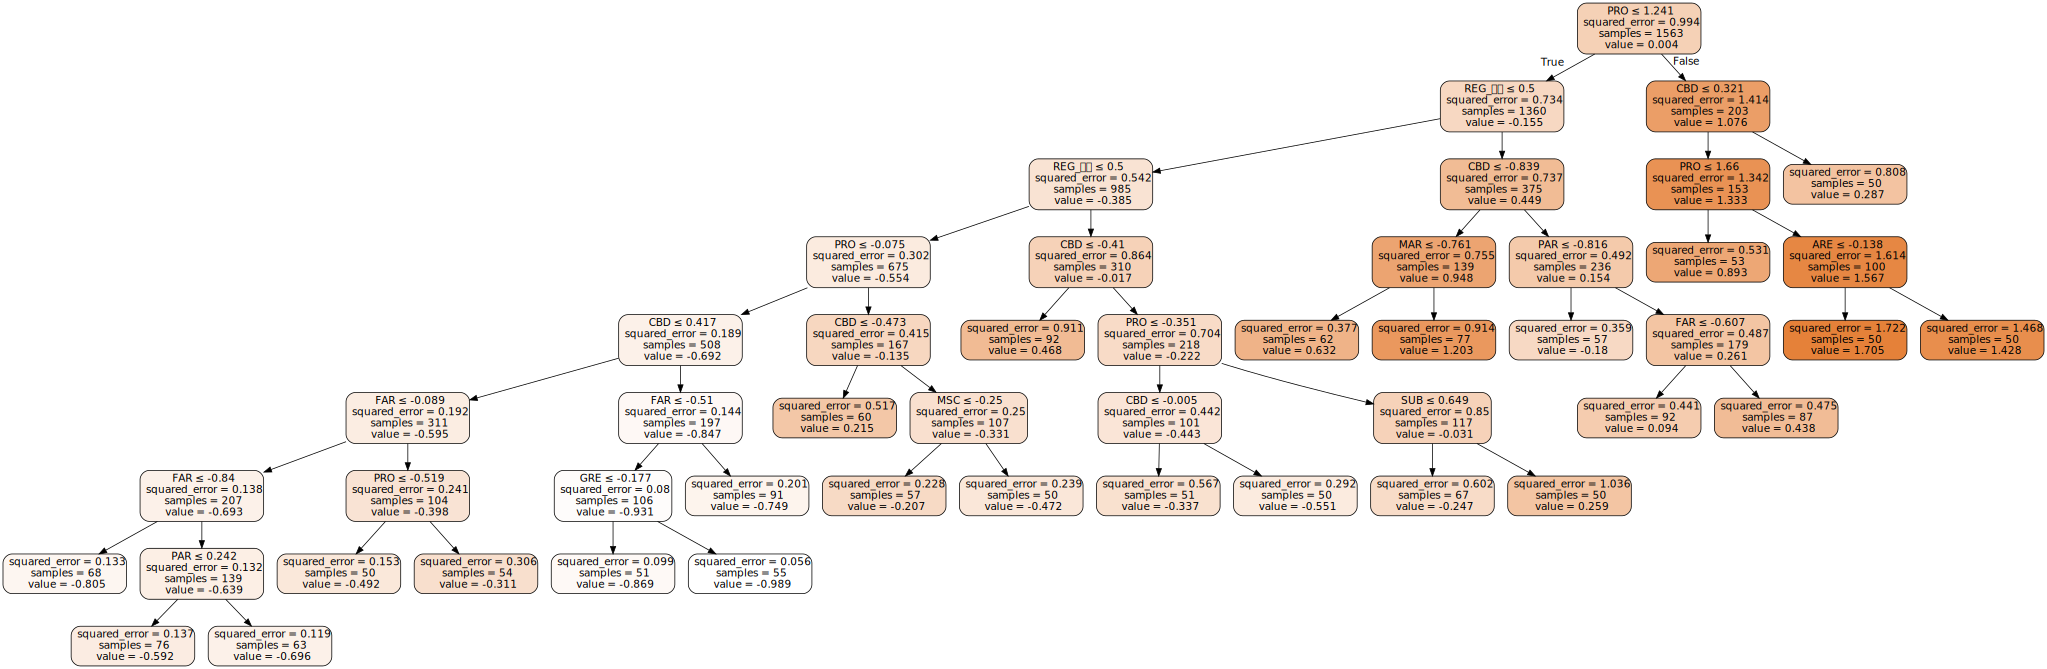

In [10]:
# 导出决策树为DOT格式
dot_data = export_graphviz(best_dt_model, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['PRI'],
                           filled=True, rounded=True,
                           special_characters=True,
                           fontname=VIS_FONT)
# 显示决策树
graph = graphviz.Source(dot_data, format='png')
graph.render(filename=f'{FIGURES_DIR}/decision_tree', view=False)
graph

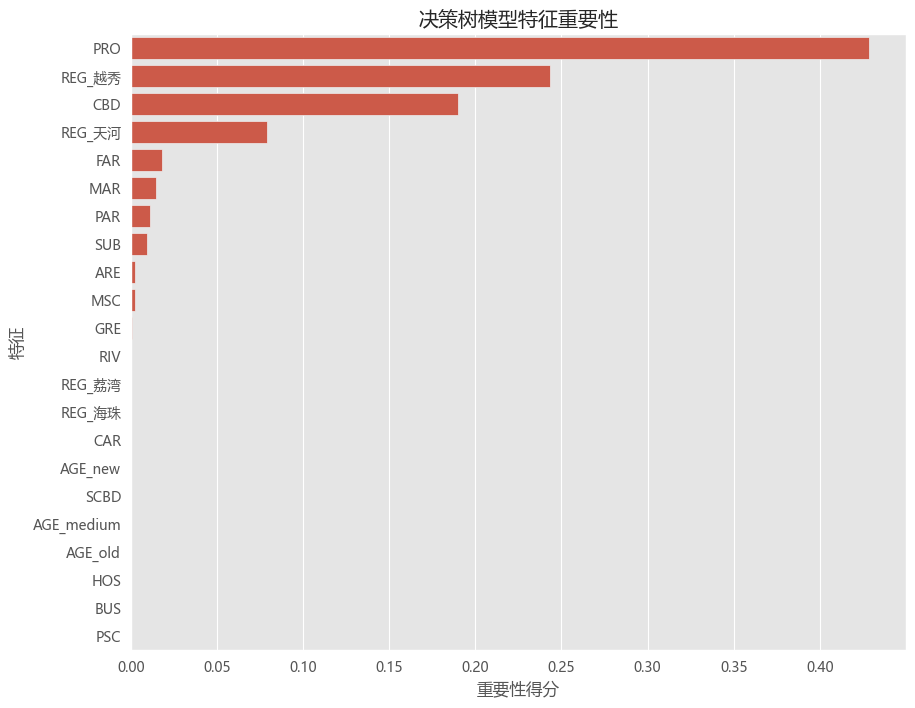

In [11]:
# 可视化特征重要性
feature_importances = pd.Series(best_dt_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('决策树模型特征重要性')
plt.xlabel('重要性得分')
plt.ylabel('特征')
plt.savefig(f'{FEATURES_RESULTS_DIR}/dt_feature_importance.png')
plt.show()

### 3.3 梯度提升回归 (Gradient Boosting)

In [12]:
# 训练模型
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=PREDICTION_RANDOM_STATE)
gb_model.fit(X_train, y_train)

# 预测与评估
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
r2_scores['梯度提升回归'] = r2_gb

print(f"梯度提升回归 - 平均平方误差 (MSE): {mse_gb:.4f}")
print(f"梯度提升回归 - R² 分数: {r2_gb:.4f}")

梯度提升回归 - 平均平方误差 (MSE): 0.5246
梯度提升回归 - R² 分数: 0.4830


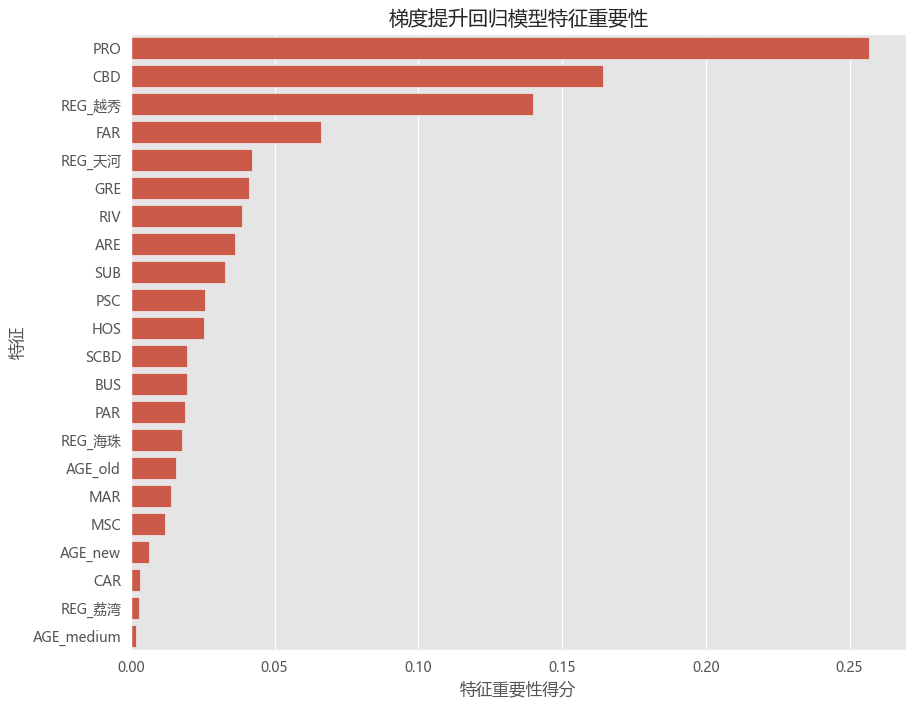

In [13]:
# 可视化特征重要性
feature_importances = pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('梯度提升回归模型特征重要性')
plt.xlabel('特征重要性得分')
plt.ylabel('特征')
plt.savefig(f'{FEATURES_RESULTS_DIR}/gb_feature_importance.png')
plt.show()

### 3.4 神经网络集成 (Neural Network Ensemble)

In [14]:
# 将数据转换为PyTorch Tensors
# 先确保所有特征列都是数值类型
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

# 创建PyTorch数据集和数据加载器
class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PriceDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

In [15]:
# 定义神经网络模型
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)  # 增加dropout比例

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [16]:
# 定义训练函数
def train_model(model, optimizer, criterion, epochs=50):
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    print("模型训练完成")

In [17]:
# 定义多个模型
input_size = X_train.shape[1]
net1 = Net(input_size)
net2 = Net(input_size)
net3 = Net(input_size)
net4 = Net(input_size)
# 定义损失函数和优化器
criterion = nn.MSELoss()
batch_size = 256
# 定义多个优化器
optimizer1 = torch.optim.RMSprop(net1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.0001)
optimizer3 = torch.optim.Adagrad(net3.parameters(), lr=0.0001)
optimizer4 = torch.optim.AdamW(net4.parameters(), lr=0.0001)

In [18]:
# 训练多个模型
for epoch in range(1000):
    for model, optimizer in zip([net1, net2, net3, net4], [optimizer1, optimizer2, optimizer3, optimizer4]):
        for batch_idx, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

In [19]:
# 对多个模型的预测进行平均
with torch.no_grad():
    predictions1 = net1(X_test_torch)
    predictions2 = net2(X_test_torch)
    predictions3 = net3(X_test_torch)
    predictions4 = net4(X_test_torch)

In [20]:
# 评估模型
# 计算平均预测值
ensemble_predictions = (predictions1 + predictions2 + predictions3 + predictions4) / 4
mse_nn = mean_squared_error(y_test_torch, ensemble_predictions)
r2_nn = r2_score(y_test_torch, ensemble_predictions)
r2_scores['神经网络(平均)'] = r2_nn

print(f"神经网络(平均) - 平均平方误差 (MSE): {mse_nn:.4f}")
print(f"神经网络(平均) - R² 分数: {r2_nn:.4f}")

神经网络(平均) - 平均平方误差 (MSE): 0.5128
神经网络(平均) - R² 分数: 0.4946


### 4.5 堆叠集成 (Stacking with GradientBoostingRegressor)

In [28]:
# 堆叠
predictions_list = [predictions1, predictions2, predictions3, predictions4]
stacked_predictions = np.column_stack(predictions_list)
# 将原始测试集的目标变量 y_test 也加入到堆叠数据中
stacked_data = np.column_stack((stacked_predictions, y_test))
# 使用 train_test_split 函数将堆叠数据划分为训练集和验证集
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(stacked_data[:, :-1], stacked_data[:, -1], test_size=PREDICTION_TEST_SIZE, random_state=PREDICTION_RANDOM_STATE)

In [32]:
# 创建元模型
meta_model = GradientBoostingRegressor(random_state=PREDICTION_RANDOM_STATE)
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [2, 3, 5],
    'n_estimators': [300, 500, 700]
}
# 使用网格搜索进行参数优化
grid_search = GridSearchCV(estimator=meta_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [36]:
grid_search.fit(X_train_meta, y_train_meta)
# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)
# 使用最佳参数训练模型
best_model = GradientBoostingRegressor(**grid_search.best_params_, random_state=PREDICTION_RANDOM_STATE)
best_model.fit(X_train_meta, y_train_meta)
# 预测与评估
y_pred_stacked = best_model.predict(X_test_meta)
mse_stacked = mean_squared_error(y_test_meta, y_pred_stacked)
r2_stacked = r2_score(y_test_meta, y_pred_stacked)
r2_scores['堆叠(神经网络+梯度提升回归)'] = r2_stacked

print(f"堆叠(神经网络+梯度提升回归) - 平均平方误差 (MSE): {mse_stacked:.4f}")
print(f"堆叠(神经网络+梯度提升回归) - R² 分数: {r2_stacked:.4f}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
堆叠(神经网络+梯度提升回归) - 平均平方误差 (MSE): 0.4248
堆叠(神经网络+梯度提升回归) - R² 分数: 0.5084


In [37]:
# 使用训练好的基线模型在训练集上生成新的特征
rf_meta_features = rf_model.predict(X_train)
dt_meta_features = best_dt_model.predict(X_train)
gb_meta_features = gb_model.predict(X_train)

# 组合成新的训练集
stacked_X_train = np.column_stack((rf_meta_features, dt_meta_features, gb_meta_features))

# 在测试集上生成新的特征
rf_test_meta = rf_model.predict(X_test)
dt_test_meta = best_dt_model.predict(X_test)
gb_test_meta = gb_model.predict(X_test)
stacked_X_test = np.column_stack((rf_test_meta, dt_test_meta, gb_test_meta))

# 训练元模型
grid_search.fit(stacked_X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
# 使用最佳参数训练元模型
best_model = GradientBoostingRegressor(**grid_search.best_params_, random_state=PREDICTION_RANDOM_STATE)
best_model.fit(stacked_X_train, y_train)

# 预测与评估
y_pred_stacked = best_model.predict(stacked_X_test)
mse_stacked = mean_squared_error(y_test, y_pred_stacked)
r2_stacked = r2_score(y_test, y_pred_stacked)
r2_scores['堆叠(基线模型+梯度提升回归)'] = r2_stacked

print(f"堆叠(基线模型+梯度提升回归) - 平均平方误差 (MSE): {mse_stacked:.4f}")
print(f"堆叠(基线模型+梯度提升回归) - R² 分数: {r2_stacked:.4f}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300}
堆叠(基线模型+梯度提升回归) - 平均平方误差 (MSE): 0.6164
堆叠(基线模型+梯度提升回归) - R² 分数: 0.3925


## 4. 模型性能综合比较

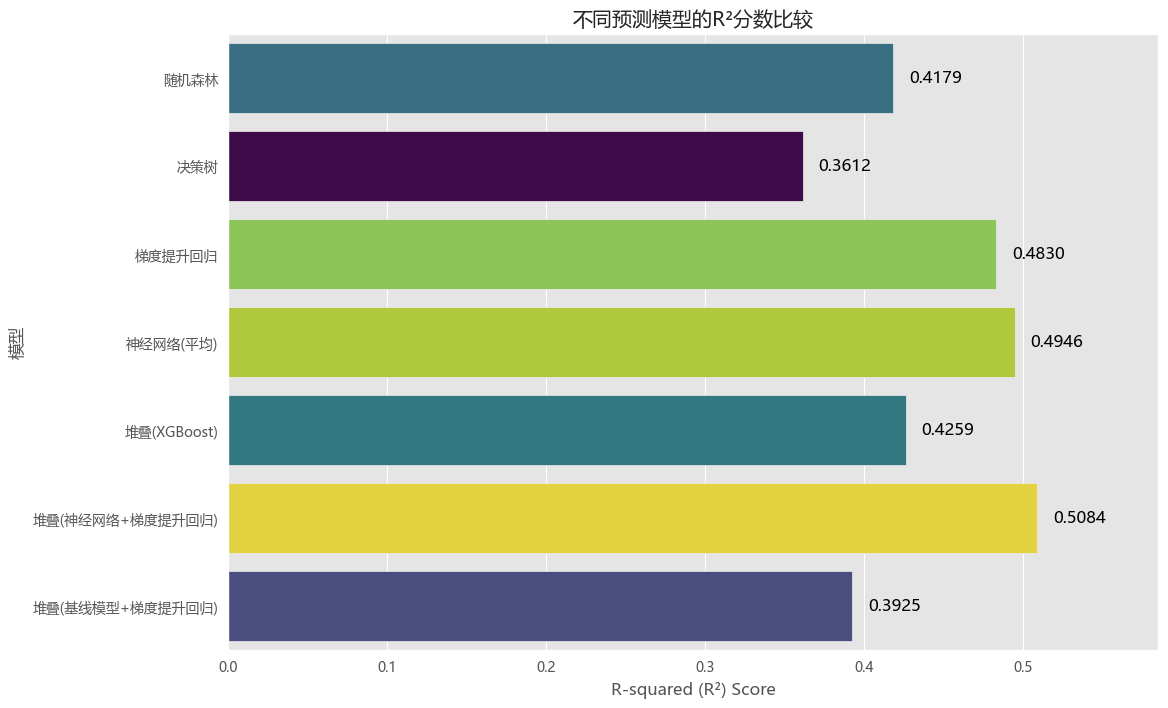

In [60]:
# 将R²分数转换为DataFrame以便于绘图
scores_df = pd.DataFrame(list(r2_scores.items()), columns=['模型', 'R² 分数'])

# 创建柱状图
plt.figure(figsize=(12, 8))
# 设置颜色映射
barplot = sns.barplot(x='R² 分数', y='模型', data=scores_df, palette='viridis', legend=False, hue='R² 分数')

# 在每个柱状图上添加R²分数
for index, row in scores_df.iterrows():
    # 让分数显示在每个柱状图的右侧
    barplot.text(row['R² 分数'] + 0.01, index, f'{row["R² 分数"]:.4f}', va='center', color='black', fontsize=12)

plt.xlabel('R-squared (R²) Score')
plt.ylabel('模型')
plt.title('不同预测模型的R²分数比较')
plt.xlim(0, max(scores_df['R² 分数']) * 1.15) # 增加x轴范围以显示所有分数
plt.savefig(f'{PREDICTION_RESULTS_DIR}/model_comparison.png')
plt.show()